#### Import Data and Libraries

In this section I create 3 datasets: 
1. Complete Dataset with all data
2. Data of individuals who have a high Climate Change Risk Perception (q2 >= 6) 
2. Data of individuals who have Low Climate Change Risk Perception (q2 <= 5) 

With all datasets I will predict pro-environmental behaviour (qb5). 

In [190]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from matplotlib import pyplot
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight


df = pd.read_csv('df-climatechange.csv')
df = df.drop([ 'qb1a'], axis = 1)
df['qb5'] = df['qb5'].replace({'No': 0, 'Yes':1})

#pd.set_option('display.max_columns', None)
df1 = df[df.qb2 >= 6]
df2 = df[df.qb2 <= 5]


In [191]:
print(len(df1))
print(len(df2))

19072
2906


#### Assumptions
https://pythonfordatascienceorg.wordpress.com/logistic-regression-python/


1. Assumption of Continuous IVs being Linearly Related to the Log Odds

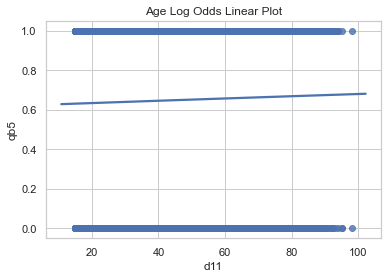

In [192]:
age = sns.regplot(x= 'd11', y= 'qb5', data= df, logistic= True, ci = None).set_title("Age Log Odds Linear Plot")
#age.figure.savefig("gre log lin.png")

In this case there is not an "S" curve line

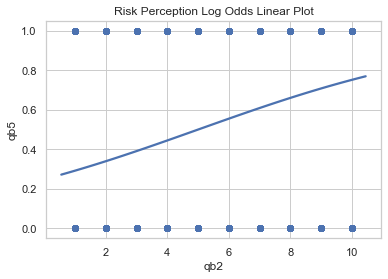

In [193]:
qb2 = sns.regplot(x= 'qb2', y= 'qb5', data= df, logistic= True, ci = None).set_title("Risk Perception Log Odds Linear Plot")


 The current plot gives you an intuition how the logistic model fits an ‘S’ curve line and how the probability changes from 0 to 1 with observed values. 

2. Assumption of Absence of Multicollinearity

In [194]:
cc = df[['qb2','d11']]
cc.corr()

,qb2,d11
qb2,1.000000,-0.018869
d11,-0.018869,1.000000


There is no correlated variables

3. Assumption of Lack of outliers

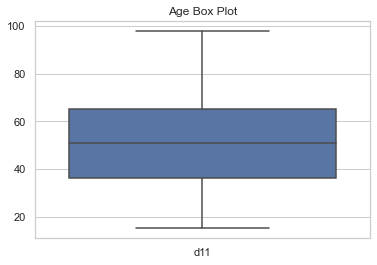

In [195]:
age_rank_box = sns.boxplot(data= df[['d11']]).set_title("Age Box Plot")


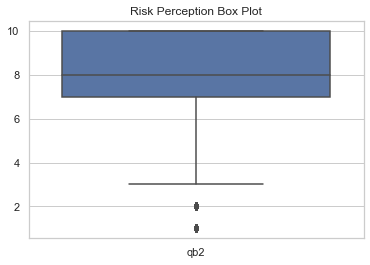

In [196]:
rp_rank_box = sns.boxplot(data= df[['qb2']]).set_title("Risk Perception Box Plot")


There are some outliers in the risk perception variable. The outliers are not so far away from the rest of the values in their respective variable. Thus, the values can be kept and used in the analysis.

In [197]:
#functions and set parameters

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]



solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

### Complete Dataset

In this part there is the complete dataset. I will predict pro-environmental behaviour (qb5). The predictors are: climate change risk perception, clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 

In [198]:

cc_num = df[['qb5', 'qb2' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.43641457, 0.76697577])

In [199]:
#find optimal parameter 


# example of grid searching key hyperparametres for logistic regression

# define dataset
# define models and parameters
model = LogisticRegression(class_weight={0: 1.43631197 , 1:0.76700502})

logreg = RandomizedSearchCV(model,grid, n_jobs=-1, cv=3, random_state = seed)
logreg = logreg.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (logreg.best_score_, logreg.best_params_))
means = logreg.cv_results_['mean_test_score']
stds = logreg.cv_results_['std_test_score']
params = logreg.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    
    

Best: 0.665952 using {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
0.656916 (0.012101) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}
0.658021 (0.012684) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}
0.665952 (0.011172) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
0.664977 (0.012879) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}
0.664717 (0.012841) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100}
0.665042 (0.012598) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}
0.664912 (0.012936) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}
0.665497 (0.011676) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}
0.664912 (0.012841) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}
0.664782 (0.012702) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0}


C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [200]:
print(logreg.best_params_)
print(logreg.best_estimator_)

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
LogisticRegression(C=0.1, class_weight={0: 1.43631197, 1: 0.76700502})


In [201]:
#fit model with optimal parameters  Threshold 0.5

print(classification_report(y_test, logreg.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.52      0.66      0.58      2296
           1       0.79      0.68      0.73      4298

    accuracy                           0.67      6594
   macro avg       0.65      0.67      0.65      6594
weighted avg       0.69      0.67      0.68      6594



(0.0, 1.0)

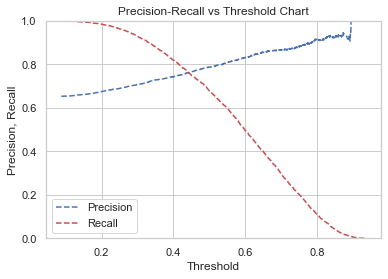

In [202]:
### Predict test_y values and probabilities based on fitted logistic  regression model
#uso modello normale

pred_y=logreg.best_estimator_.predict(X_test) 

probs_y=logreg.best_estimator_.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first  column of  array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])




Best Threshold=0.484861, G-Mean=0.669


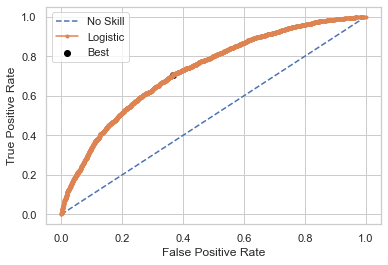

In [203]:
#ROC AUC

yhat = logreg.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


Text(0.5, 12.5, 'Predicted label')

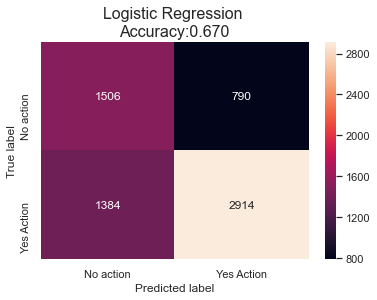

In [204]:
#confusion matrix

y_scores = logreg.best_estimator_.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test,logreg.best_estimator_.predict(X_test))
cm = pd.DataFrame(cm,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])



sns.heatmap(cm, annot=True, fmt="d")

plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, logreg.best_estimator_.predict(X_test)) ), fontdict= {'fontsize' : 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')

    

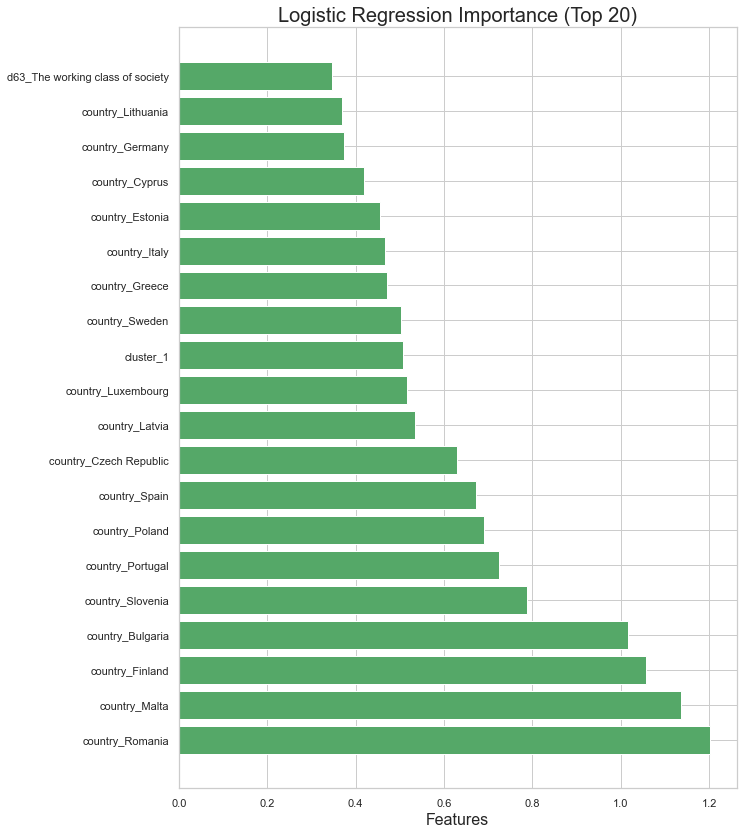

In [205]:
coefs = np.abs(logreg.best_estimator_.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure(figsize = (10, 14))
plt.title("Feature importances (Logistic Regression)")
plt.barh(range(20), coefs[indices[:20]],
       color="g")
plt.yticks(range(20), X.columns[indices[:20]], rotation=0, ha='right')
#plt.subplots_adjust(bottom=0.3)


plt.title('Logistic Regression Importance (Top 20)',
          fontdict= {'fontsize' : 20}
         )
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

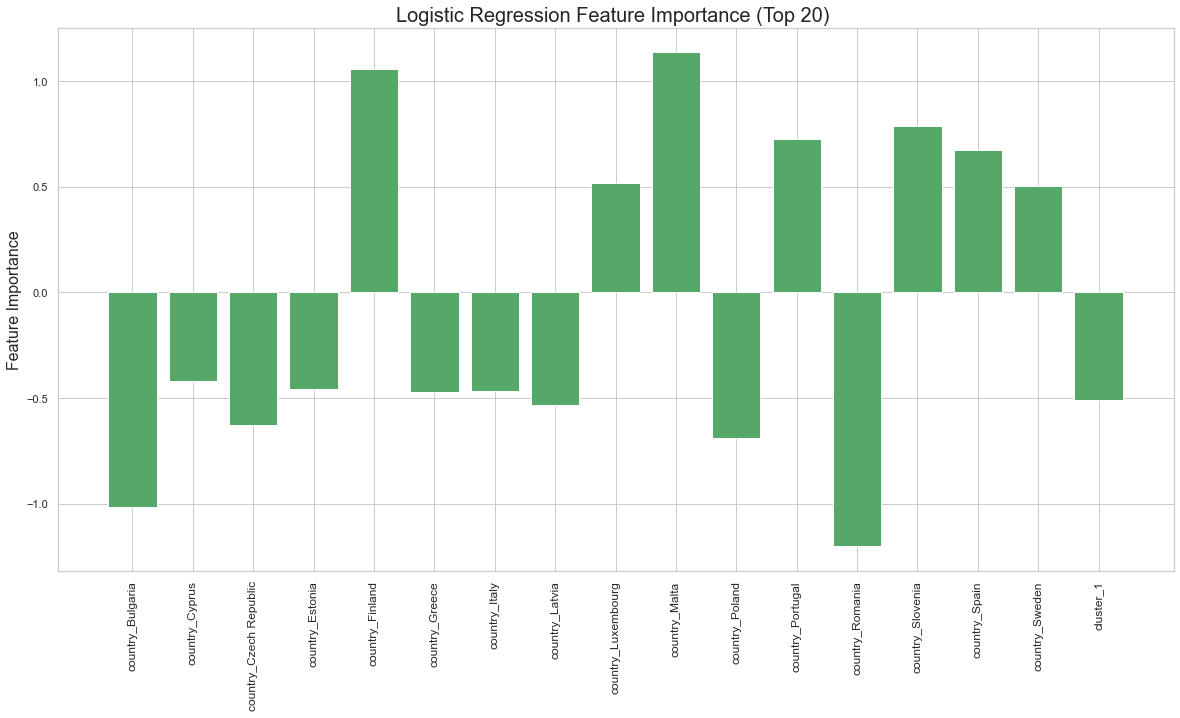

In [216]:
#top 20
model = SelectFromModel(logreg.best_estimator_, threshold=0.41, prefit=True)

feature_idx = model.get_support() 
feature_name = X.columns[feature_idx]
X_new = model.transform(X)

# Plot
importance = logreg.best_estimator_.coef_[0]

#for i,v in enumerate(importance):
#    if np.abs(v)>=1e-5:
#        print('Feature: %0d, Score: %.5f' % (i,v))
sel = importance[np.abs(importance)>=0.41]
# plot feature importance
plt.figure(figsize=(20, 10))
pyplot.bar([x for x in feature_name], sel, color="g")
pyplot.xticks(fontsize=12, rotation=90)
pyplot.ylabel('Feature Importance', fontsize = 16)
plt.title('Logistic Regression Feature Importance (Top 20) ', fontdict= {'fontsize' : 20})

pyplot.show()

In [224]:
lg1 = pd.DataFrame({'variable' : X.columns[indices[:]], 'importance_lg' : logreg.best_estimator_.coef_[0]})    


lg1.to_csv('imp.csv', index=False, encoding='utf-8')


### High Risk Perception


In this part there is data of individuals who have a high Climate Change Risk Perception (q2 >= 6).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes

In [163]:
cc_num = df1[['qb5' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 101 # so that the result is reproducible

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,  random_state = seed,stratify=y)


class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.56726931, 0.73424266])

In [164]:
#find optimal parameter 

model = LogisticRegression(class_weight={0: 1.56837406 , 1:0.73400044})

logreg = RandomizedSearchCV(model,grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0, random_state = seed)
logreg = logreg.fit(X_train, y_train)
    
print(logreg.best_params_)
print(logreg.best_estimator_)

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
LogisticRegression(C=0.1, class_weight={0: 1.56837406, 1: 0.73400044})


C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [165]:
#fit model with optimal parameters  Threshold 0.5

print(classification_report(y_test, logreg.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.47      0.64      0.54      1825
           1       0.80      0.66      0.72      3897

    accuracy                           0.65      5722
   macro avg       0.63      0.65      0.63      5722
weighted avg       0.69      0.65      0.66      5722



(0.0, 1.0)

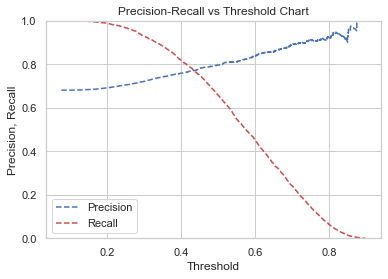

In [166]:
### Predict test_y values and probabilities based on fitted logistic  regression model
#uso modello normale

pred_y=logreg.best_estimator_.predict(X_test) 

probs_y=logreg.best_estimator_.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first  column of  array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


Best Threshold=0.518248, G-Mean=0.653


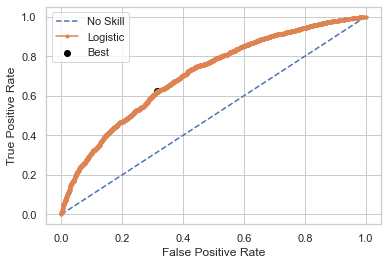

In [167]:
#roc
yhat = logreg.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()



Text(0.5, 12.5, 'Predicted label')

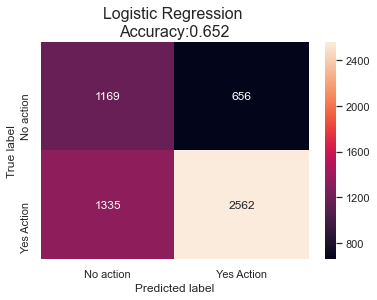

In [168]:
#confusion matrix 

    

y_scores = logreg.best_estimator_.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test,logreg.best_estimator_.predict(X_test))
cm = pd.DataFrame(cm,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])



sns.heatmap(cm, annot=True, fmt="d")

plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, logreg.best_estimator_.predict(X_test)) ), fontdict= {'fontsize' : 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')

    

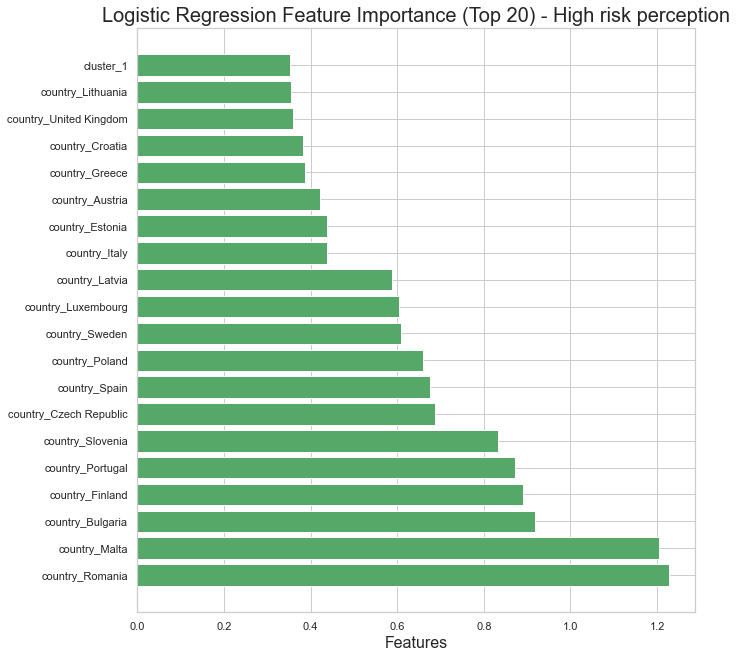

In [169]:
coefs = np.abs(logreg.best_estimator_.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure(figsize = (10, 14))
plt.title("Feature importances (Logistic Regression)")
plt.barh(range(20), coefs[indices[:20]],
       color="g", align="center")
plt.yticks(range(20), X.columns[indices[:20]], rotation=0, ha='right')
plt.subplots_adjust(bottom=0.3)


#feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
plt.title('Logistic Regression Feature Importance (Top 20) - High risk perception', fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

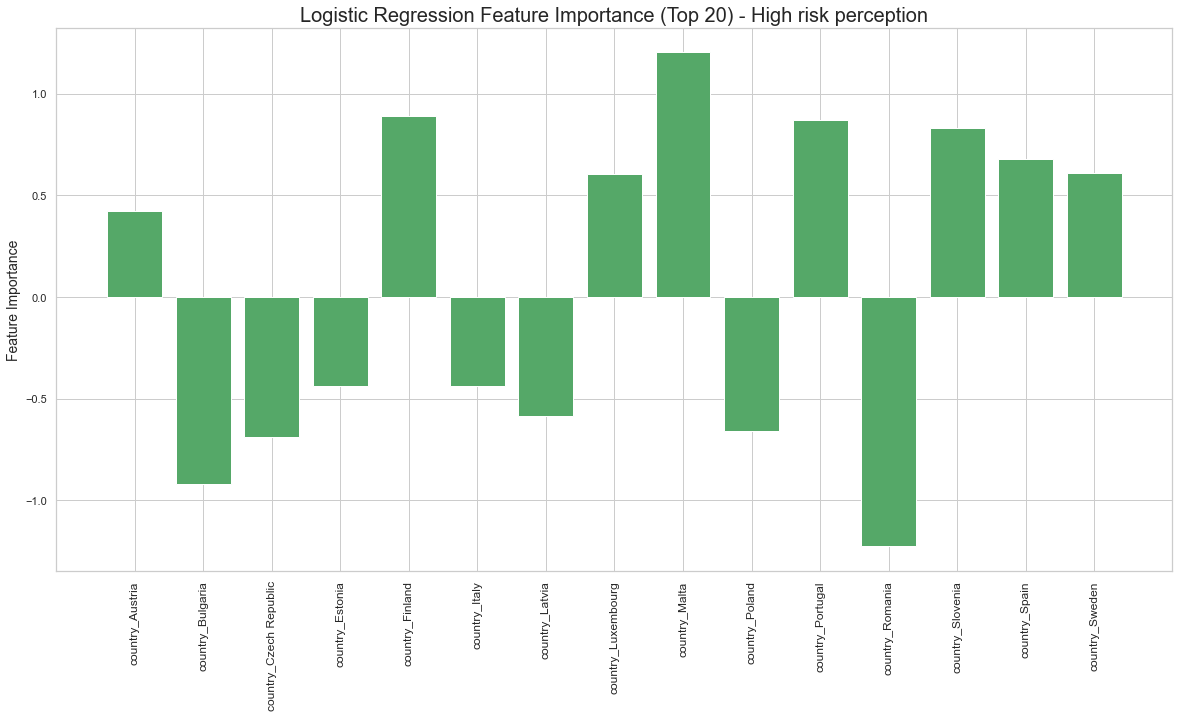

In [170]:
#top 20
model = SelectFromModel(logreg.best_estimator_, threshold=0.41, prefit=True)

feature_idx = model.get_support() 
feature_name = X.columns[feature_idx]
X_new = model.transform(X)

# Plot
importance = logreg.best_estimator_.coef_[0]

#for i,v in enumerate(importance):
#    if np.abs(v)>=1e-5:
#        print('Feature: %0d, Score: %.5f' % (i,v))
sel = importance[np.abs(importance)>=0.41]
# plot feature importance
plt.figure(figsize=(20, 10))
pyplot.bar([x for x in feature_name], sel, color="g")
pyplot.xticks(fontsize=12, rotation=90)
pyplot.ylabel('Feature Importance', fontsize = 14)
plt.title('Logistic Regression Feature Importance (Top 20) - High risk perception', fontdict= {'fontsize' : 20})

pyplot.show()

In [171]:
for i in range(len(logreg.best_estimator_.coef_[0])): 
    

    print(X.columns[indices[:]][i],logreg.best_estimator_.coef_[0][i])


country_Romania 0.0023729552937778644
country_Malta -0.01562291806715598
country_Bulgaria 0.1335751230461352
country_Finland -0.14253936732367273
country_Portugal 0.1990441384393641
country_Slovenia -0.042774359715313286
country_Czech Republic -0.13831560969176987
country_Spain -0.12115856532894773
country_Poland 0.11452557201653049
country_Sweden 0.4213218938283206
country_Luxembourg -0.11262707909605486
country_Latvia -0.9181525631073228
country_Italy -0.3829588191267966
country_Estonia -0.324623600211666
country_Austria -0.6874793603666011
country_Greece 0.13472258849093752
country_Croatia -0.4381863973979426
country_United Kingdom 0.8912949443353061
country_Lithuania 0.09293052942313067
cluster_1 0.2949133760247767
cluster_2 -0.38688640709132893
country_Slovakia 0.09264681189736157
country_Cyprus -0.08183925382547952
country_Germany -0.4382019873239261
d63_The working class of society -0.5870884959541767
d63_The upper middle class of society -0.355661178671326
d63_The higher class 

### Low Risk Perception


In this part there is data of individuals who have a low Climate Change Risk Perception (q2 <= 5).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes

In [172]:
cc_num = df2[['qb5' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 101  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)


class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))


print(class_weights)



[0.92707384 1.08537887]


In [173]:
#find optimal parameter 

model = LogisticRegression(class_weight={0: 0.92119565  , 1:1.09354839})

logreg = RandomizedSearchCV(model,grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0)
logreg = logreg.fit(X_train, y_train)
    
print(logreg.best_params_)
print(logreg.best_estimator_)


{'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}
LogisticRegression(C=100, class_weight={0: 0.92119565, 1: 1.09354839})


C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [174]:
print(classification_report(y_test, logreg.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       470
           1       0.60      0.62      0.61       402

    accuracy                           0.63       872
   macro avg       0.63      0.63      0.63       872
weighted avg       0.63      0.63      0.63       872



(0.0, 1.0)

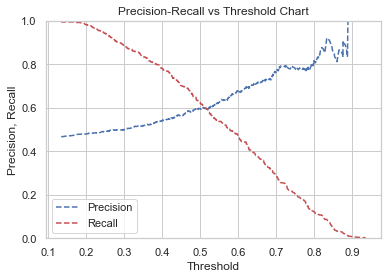

In [175]:
### Predict test_y values and probabilities based on fitted logistic  regression model

# predict probabilities

pred_y=logreg.best_estimator_.predict(X_test) 

probs_y=logreg.best_estimator_.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first  column of  array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


Best Threshold=0.488780, G-Mean=0.636


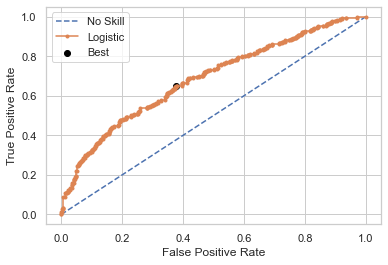

In [176]:
# predict probabilities
yhat = logreg.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


Text(0.5, 12.5, 'Predicted label')

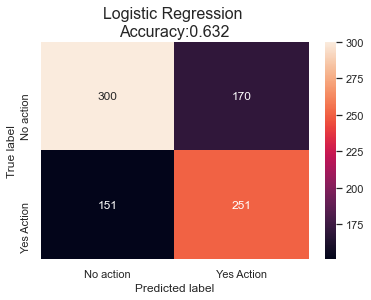

In [177]:
#confusion matrix 


cm = confusion_matrix(y_test,logreg.best_estimator_.predict(X_test))
cm = pd.DataFrame(cm,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])



sns.heatmap(cm, annot=True, fmt="d")

plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, logreg.best_estimator_.predict(X_test)) ), fontdict= {'fontsize' : 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


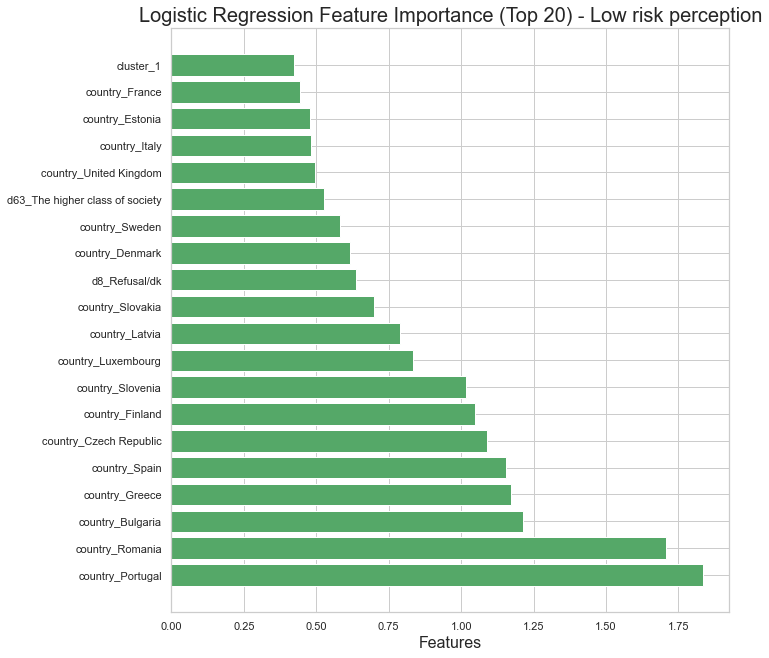

In [178]:
coefs = np.abs(logreg.best_estimator_.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure(figsize = (10, 14))
plt.title("Feature importances (Logistic Regression)")
plt.barh(range(20), coefs[indices[:20]],
       color="g", align="center")
plt.yticks(range(20), X.columns[indices[:20]], rotation=0, ha='right')
plt.subplots_adjust(bottom=0.3)


#feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
plt.title('Logistic Regression Feature Importance (Top 20) - Low risk perception', fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

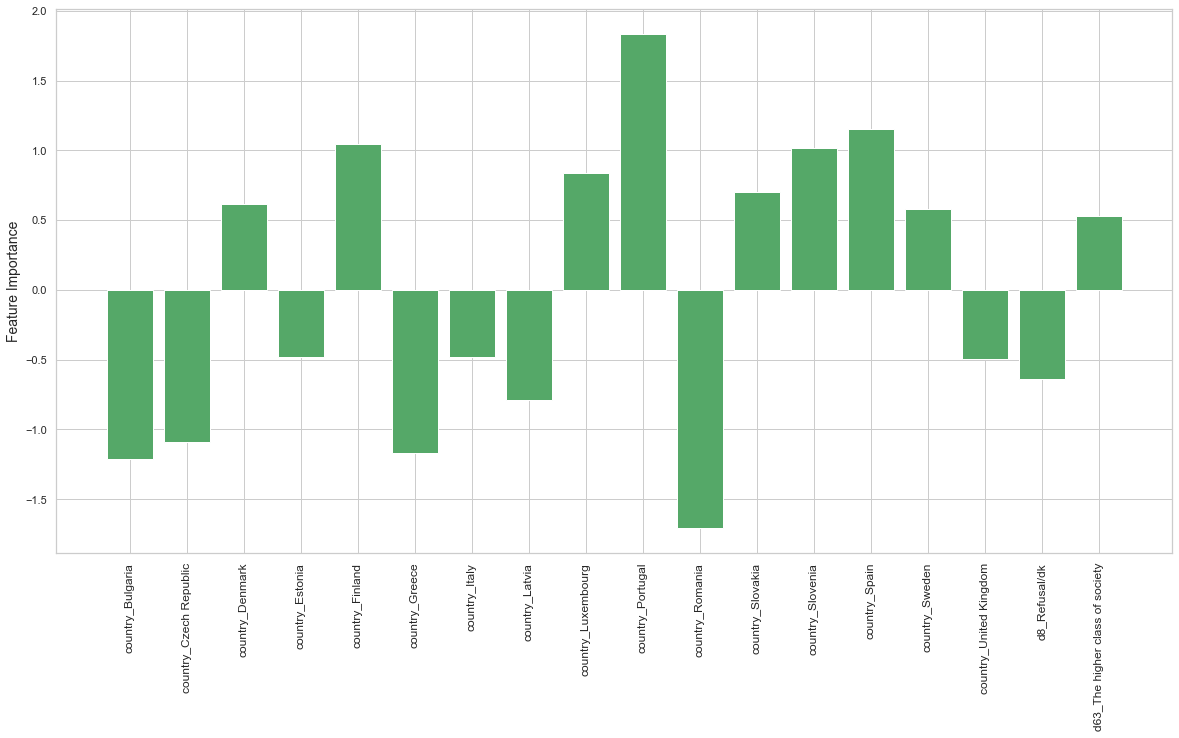

In [179]:
#top 20
model = SelectFromModel(logreg.best_estimator_, threshold=0.45, prefit=True)

feature_idx = model.get_support() 
feature_name = X.columns[feature_idx]
X_new = model.transform(X)

# Plot
importance = logreg.best_estimator_.coef_[0]
indices = np.argsort(coefs)[::-1]

#for i,v in enumerate(importance):
#    if np.abs(v)>=1e-5:
#        print('Feature: %0d, Score: %.5f' % (i,v))
sel = (importance[np.abs(importance)>=0.45])
# plot feature importance
plt.figure(figsize=(20, 10))
pyplot.bar([x for x in feature_name], sel, color = 'g')
pyplot.xticks(fontsize=12, rotation=90)
pyplot.ylabel('Feature Importance', fontsize = 14)
pyplot.show()



In [180]:
for i in range(len(logreg.best_estimator_.coef_[0])): 
    

    print(X.columns[indices[:]][i],logreg.best_estimator_.coef_[0][i])


country_Portugal 0.008130343447899945
country_Romania 0.1009840963392308
country_Bulgaria -0.013556648853584196
country_Greece -0.12913584684551807
country_Spain 0.044802901305418086
country_Czech Republic 0.09195173995848761
country_Finland -0.17633129060608288
country_Slovenia -0.11667034294862964
country_Luxembourg 0.03538529424661159
country_Latvia -0.03408101476622689
country_Slovakia 0.09466024175057781
d8_Refusal/dk -1.2135935845412793
country_Denmark -0.2658359802239154
country_Sweden 0.20107300463603467
d63_The higher class of society -1.0878325114249148
country_United Kingdom 0.6178095065950758
country_Italy -0.4789987064762177
country_Estonia 1.0467651507363895
country_France -0.4452668090271892
cluster_1 0.3847298257307984
d63_The working class of society -1.173030148378958
country_Germany -0.14803080833361423
d7_Single 0.2057102923635031
d8_20+ years old -0.4823700918219341
country_Poland -0.7888359152274966
cluster_2 -0.18239938543875858
country_Malta 0.8353021133572417
c

#### REFERENCES 

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

https://stackoverflow.com/questions/65491584/regularized-l1-logistic-regression-feature-selection-returns-different-coef-whe


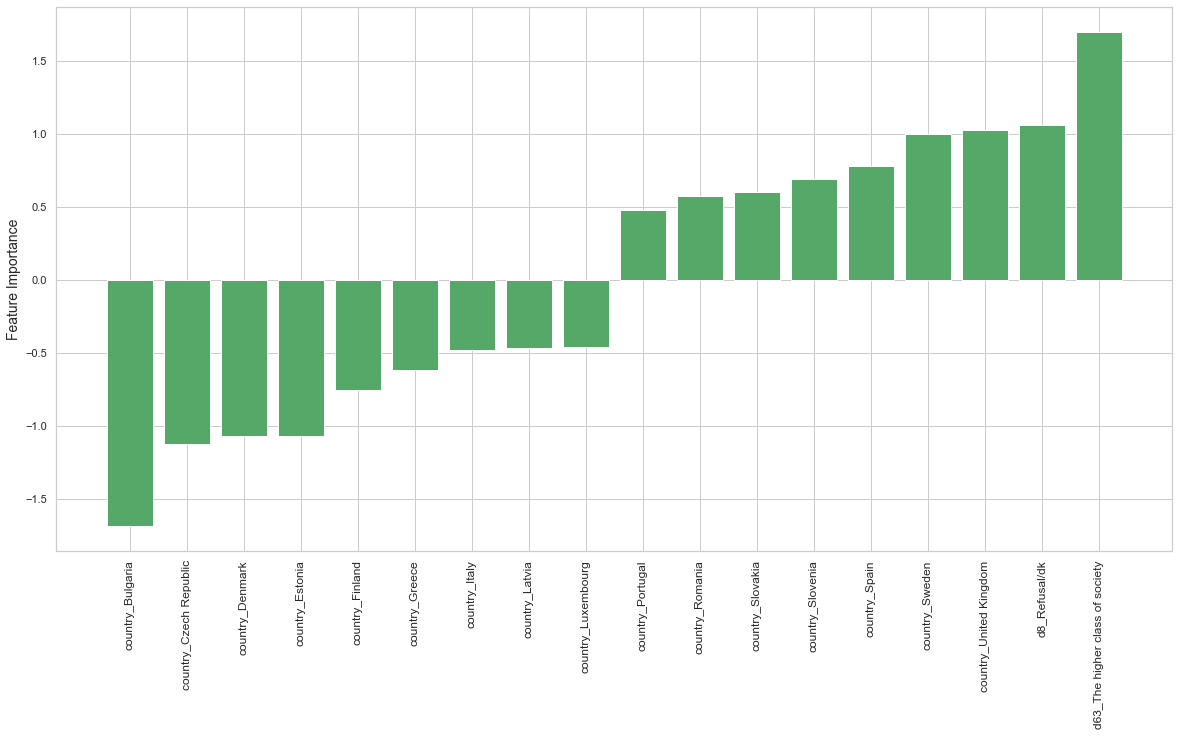

In [144]:
#top 20
model = SelectFromModel(logreg.best_estimator_, threshold=0.45, prefit=True)

feature_idx = model.get_support() 
feature_name = X.columns[feature_idx]
X_new = model.transform(X)

# Plot
importance = logreg.best_estimator_.coef_[0]
indices = np.argsort(coefs)[::-1]

#for i,v in enumerate(importance):
#    if np.abs(v)>=1e-5:
#        print('Feature: %0d, Score: %.5f' % (i,v))
sel = sorted(importance[np.abs(importance)>=0.45])
# plot feature importance
plt.figure(figsize=(20, 10))
pyplot.bar([x for x in feature_name], sel, color = 'g')
pyplot.xticks(fontsize=12, rotation=90)
pyplot.ylabel('Feature Importance', fontsize = 14)
pyplot.show()
